In [ ]:
import numpy as np
import sys,csv,os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
import tensorflow.keras  as keras
import tensorflow.keras.backend as K
import tensorflow.keras.layers
from tensorflow.keras.preprocessing import image
csv.field_size_limit(sys.maxsize)
tf.compat.v1.disable_eager_execution()
!nvidia-smi

Fri Sep 25 00:09:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    13W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
"""
IMAGE_DIR = DIR+"/images_small/" # img dataset directory
MASK_DIR = DIR+"/masks_small/"# segmentation target dataset directory
gdzie oba z tych folderów będą zawierały zdjęcia z odpowiadającymi im maskami 
segmentacji według kategorii:
CATEGORIES={0:'background',1:'shirt,top',2:'sweater,cardigan',
            3:'jacket',4:'vest',5:'pants,shorts,skirt',
            6:'coat',7:'dress',8:'other',9:'head accesory',
            10:'tie',11:'shoe',12:'bag',13:'accessory'}
"""

Mounted at /content/drive


# Hyperparameters+backend for unet

In [ ]:
NETWORK_TYPE = "MobileNet"
NUMBER_OF_APPAREL = 27
NUMBER_OF_REDUCED_APPAREL = 13
NUMBER_OF_CATEGORIES = NUMBER_OF_APPAREL
TRAIN_SPLIT = 0.8
DATA_FRACTION = 1.0
IMG_SHAPE = (256,256)
INPUT_SHAPE = IMG_SHAPE
CHANNEL_FORMAT = 'channels_last' # channel_first better
BATCH_SIZE=128
DIR = '/content/drive/My Drive/SDD'
IMAGE_DIR = DIR+"/images_small/" # img dataset directory
MASK_DIR = DIR+"/masks_small/"# segmentation target dataset directory
USE_DICE=True
REDUCE_CATEGORIES=True
if(REDUCE_CATEGORIES==True):  
                              NUMBER_OF_CATEGORIES = NUMBER_OF_REDUCED_APPAREL
                              MASK_DIR = DIR+"/masks_small_reduced/masks/"
                              CATEGORIES={0:'background',1:'shirt,top',2:'sweater,cardigan',
                                          3:'jacket',4:'vest',5:'pants,shorts,skirt',
                                          6:'coat',7:'dress',8:'other',9:'head accesory',
                                          10:'tie',11:'shoe',12:'bag',13:'accessory'}
# whether to use dice loss for unet segmentation
if(USE_DICE==False):          
  CHECKPOINT_DIR = DIR+'/checkpoints/256_'+NETWORK_TYPE+".ckpt"
  #WEIGHT_DIR = DIR+'/checkpoints/'+NETWORK_TYPE+".h5"
else:                         
  CHECKPOINT_DIR = DIR+'/checkpoints/256_'+NETWORK_TYPE+"_dice.ckpt"
  #WEIGHT_DIR = DIR+'/checkpoints/'+NETWORK_TYPE+"_dice.h5"
if(CHANNEL_FORMAT=='channels_first'): INPUT_SHAPE = (3,) + INPUT_SHAPE
else:                                 INPUT_SHAPE += (3,)
K.clear_session()

# Construct model depending on chosen backend

In [ ]:
from tensorflow.keras.layers import Dense,GlobalAvgPool2D,BatchNormalization,Dropout
from tensorflow.keras.models import Model


def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def construct_model(network_type="MobileNet",input_shape=INPUT_SHAPE,freeze_base=True):
    K.clear_session()
    if(network_type == "InceptionV3"):
        from tensorflow.keras.applications.inception_v3 import InceptionV3
        from tensorflow.keras.applications.inception_v3 import preprocess_input
        base_model = InceptionV3(weights='imagenet', include_top=False,input_shape = input_shape)
        preprocess_input_ = preprocess_input
        #break
    elif(network_type == "resnet50v2"):
        from tensorflow.keras.applications.resnet_v2 import ResNet50V2
        from tensorflow.keras.applications.resnet_v2 import preprocess_input
        base_model = ResNet50V2(weights='imagenet', include_top=False,input_shape = input_shape)
        preprocess_input_ = preprocess_input
        #break  
        layer_names = [
        'conv1_conv',   # 64x64
        'conv2_block3_1_relu',   # 32x32
        'conv3_block4_1_relu',   # 16x16
        'conv4_block6_1_relu',  # 8x8
        'post_relu',      # 4x4
        ]     
        up_stack = [
        upsample(512, 3),  # 4x4 -> 8x8
        upsample(256, 3),  # 8x8 -> 16x16
        upsample(128, 3),  # 16x16 -> 32x32
        upsample(64, 3),   # 32x32 -> 64x64
        ]     
    elif(network_type == "MobileNet"):
        from tensorflow.keras.applications import MobileNetV2
        from tensorflow.keras.applications.mobilenet_v2 import preprocess_input 
        base_model = MobileNetV2(weights='imagenet', include_top=False,input_shape = input_shape)
        preprocess_input_ = preprocess_input
        layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
        ]    
        up_stack = [
        upsample(512, 3),  # 4x4 -> 8x8
        upsample(256, 3),  # 8x8 -> 16x16
        upsample(128, 3),  # 16x16 -> 32x32
        upsample(64, 3),   # 32x32 -> 64x64
        ]
    layers = [base_model.get_layer(name).output for name in layer_names]
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
    if(freeze_base==True):
      down_stack.trainable = False

    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
      x = up(x)
      concat = tf.keras.layers.Concatenate()
      x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        NUMBER_OF_CATEGORIES+1, 3, strides=2,
        padding='same')  
    x = last(x)
    #x = keras.activations.softmax(x,axis=-1)
    return tf.keras.Model(inputs=inputs, outputs=x),preprocess_input_

model,preprocess_input_fn = construct_model(network_type=NETWORK_TYPE,
                                            input_shape=INPUT_SHAPE,
                                            freeze_base=True)

model.summary()
#for i, layer in enumerate(model.layers):
#    print(i, layer.name, layer.trainable)

9412608/9406464 [==============================] - 0s 0us/step
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       [(None, 128, 128, 96 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         multiple             1476608     functional_1[0][4]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 16, 16, 1088) 0           sequential[0][0]                 
                        

# Define tf.Dataset objects for the NN

In [ ]:
seed=1
image_datagen = image.ImageDataGenerator(
                      
                      validation_split=0.1,
                      preprocessing_function=preprocess_input_fn)
mask_datagen = image.ImageDataGenerator(
                      validation_split=0.1)
train_image_generator = image_datagen.flow_from_directory(
        IMAGE_DIR,
        target_size=IMG_SHAPE,
        batch_size=BATCH_SIZE,
        class_mode=None,
        interpolation='nearest',
        subset='training',      
        seed=seed)
train_mask_generator = mask_datagen.flow_from_directory(
        MASK_DIR,
        target_size=IMG_SHAPE,
        batch_size=BATCH_SIZE,
        class_mode=None,
        color_mode='grayscale',
        interpolation='nearest',
        subset='training',
        seed=seed)
val_image_generator = image_datagen.flow_from_directory(
        IMAGE_DIR,
        target_size=IMG_SHAPE,
        batch_size=BATCH_SIZE,
        class_mode=None,
        interpolation='nearest',
        subset='validation',      
        seed=seed)
val_mask_generator = mask_datagen.flow_from_directory(
        MASK_DIR,
        target_size=IMG_SHAPE,
        batch_size=BATCH_SIZE,
        class_mode=None,
        color_mode='grayscale',
        interpolation='nearest',
        subset='validation',
        seed=seed)
train_generator=zip(train_image_generator,train_mask_generator)
val_generator=zip(val_image_generator,val_mask_generator)
steps_per_epoch = len(train_image_generator)
val_steps = len(val_image_generator)
print("Steps per epoch: "+str(steps_per_epoch))

Found 14728 images belonging to 1 classes.
Found 14728 images belonging to 1 classes.
Found 1636 images belonging to 1 classes.
Found 1636 images belonging to 1 classes.
Steps per epoch: 116


# Define losses

In [ ]:
from tensorflow.keras.optimizers import Nadam,Adam
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy,binary_crossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
import datetime as dt
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

#A soft Dice loss is calculated for each class separately and then averaged to yield a final score. 

def soft_dice_metric(y_true, y_pred, epsilon=1e-6): 
    ''' 
    Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the `channels_last` format.
  
    # Arguments
        y_true: b x X x Y x 1 Sparse encoding of ground truth
        y_pred: b x X x Y x c Network output, must apply softmax
        epsilon: Used for numerical stability to avoid divide by zero errors
    '''
    #y_true = tf.keras.utils.to_categorical(y_true, num_classes=NUMBER_OF_CATEGORIES+1) #change sparse->categorical
    #print(y_true.shape)
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=NUMBER_OF_CATEGORIES+1) #change sparse->categorical
    #print(y_true.shape)
    y_true = K.squeeze(y_true,3)
    #print(y_pred.shape)
    #print(y_pred[0,10,10,:])
    y_pred = K.softmax(y_pred) #softmax over channels
    #print(K.eval(y_pred[0,10,10,:]))
    #print(y_pred.shape)
    #print(y_true.shape)
    # skip the batch and class axis for calculating Dice score
    axes = (1,2) # pixel axes
    numerator = 2. * K.sum(y_pred * y_true, axes)
    #print(K.eval(numerator))
    denominator = K.sum(K.square(y_pred) + K.square(y_true), axes)
    #print(K.eval(denominator))
    return K.mean((numerator + epsilon) / (denominator + epsilon)) # average over classes and batch#
def soft_dice_loss(y_true, y_pred):
  return 1 - soft_dice_metric(y_true,y_pred)
tb = TensorBoard(log_dir="./logs/"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),profile_batch=0)
reducelr = ReduceLROnPlateau(monitor='val_loss',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0000,
                             cooldown=0,
                             min_lr=0.0000001)
earlyStop = EarlyStopping(patience=20,monitor='val_loss',restore_best_weights=True)
checkpoint =ModelCheckpoint(CHECKPOINT_DIR,save_weights_only=True,verbose=1,save_best_only=True,monitor='val_loss')
callbacks = [reducelr,earlyStop,checkpoint]


# Compile & Fit

In [ ]:
if(USE_DICE==True):
  model.compile(optimizer='adam',
             loss=soft_dice_loss, 
             metrics=['accuracy'])
else:
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [ ]:
status_load =model.load_weights(CHECKPOINT_DIR)

In [ ]:
model.fit(train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=100,
        validation_data=val_generator,
        validation_steps = val_steps,
        callbacks=callbacks)
model.save_weights(CHECKPOINT_DIR,save_format="h5")

Epoch 1/100
 48/116 [===========>..................] - ETA: 1:15:49 - batch: 23.5000 - size: 128.0000 - loss: 0.2310 - accuracy: 0.7889

OSError: ignored

# Define functions to visualize predictions
Also define function that fills out "unidentified" mask category with cv2.watershed 

In [ ]:
import json
with open(DIR+'/label_descriptions.json', 'r') as f:
        apparel_labels = json.load(f)
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import cv2 as cv
from mpl_toolkits import axes_grid1

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    cbar = im.axes.figure.colorbar(im, cax=cax, **kwargs)
    cbar.ax.set_yticklabels(list(CATEGORIES.values())+["Unidentified"])
    return cbar

colours = {**mcolors.BASE_COLORS, **mcolors.TABLEAU_COLORS}
colours = dict(list(colours.items())[:len(CATEGORIES)+1])
cmap = mcolors.ListedColormap([key for key in colours.keys()])
bounds=[i for i in range(len(colours.keys()))]
bounds[1]=0.9
norm = mcolors.BoundaryNorm(bounds, cmap.N)
def get_watershed(img,m,thres,thres_replace):
  img *= 255.0/img.max() 
  img = img.astype(np.uint8)
  if(thres!=0 and thres_replace>=len(CATEGORIES)):    
    m+=1 #change markers to make space for 0 label
    m=np.where(m==len(CATEGORIES)+1,0,m) #change unkonown label to 0
  m_post = cv.watershed(img,m)
  m_post =cv.UMat.get(m_post)
  m_post = np.where(m_post==-1,1,m_post)
  if(thres!=0 and thres_replace>=len(CATEGORIES)):
    m_post-=1
  return m_post
def display(img,m,m_pred,m_post):
  plt.figure(figsize=(15, 15))
  display_list = [img,m,m_pred,m_post]
  n_plots = sum([0 if i is None else 1 for i in display_list])
  title = ['Input Image', 'True Mask', 'Predicted Mask','Postprocessing mask']
  plt.subplot(1, n_plots, 1)
  plt.title(title[0])
  plt.imshow(np.squeeze(display_list[0]),interpolation='nearest')
  plt.axis('off')
  i=1
  for iter in display_list[1:]:
    if(iter is None): continue
    plt.subplot(1, n_plots, i+1)
    plt.title(title[i])
    im = plt.imshow(np.squeeze(iter),interpolation='nearest',cmap=cmap,norm=norm)
    plt.axis('off')
    i+=1
  add_colorbar(im,ticks=list(range(len(CATEGORIES)))+[len(CATEGORIES)])
  plt.show()

def create_mask(pred_mask,thres,thres_replace):
  if(thres!=0):
    pred_mask = K.eval(K.softmax(pred_mask,axis=-1))
    mask_pred_mask = np.where(pred_mask>thres,1,0)  
    new_pred_mask = np.argmax(pred_mask*mask_pred_mask, axis=-1)
    if(thres_replace != 0 and thres !=0):
      uncertain_pred_mask = np.max(mask_pred_mask, axis=-1)
      new_pred_mask = np.where(uncertain_pred_mask==0,thres_replace,new_pred_mask)
  else:
    new_pred_mask = np.argmax(pred_mask, axis=-1)
  return new_pred_mask

def show_predictions(x,mask, num=1,thres=0.0,thres_replace=0,use_postprocessing=None,used_model=model):
  #postprocessing possibilities: None,wateshed,grabcut
    #plt.figure(figsize=(10,2))
    #plt.bar(range(len(CATEGORIES)),1,color=[v for v in colours.values()])
    #plt.xticks(range(len(CATEGORIES)), CATEGORIES.values(), rotation=90)
    #plt.show()
    #pred_mask = used_model.predict(x)
    masks=[]
    post_masks=[]
    pred_masks=[]
    for i in range(num):
      img = x[i]
      if(img.ndim==3): img=img[None,...]
      pred_mask = used_model.predict(img)
      pred_masks.append(pred_mask)
     #print("Dice metric: ")
      m = None if mask is None else mask[i:i+1]
      #if not(m is None):
      #  print(K.eval(soft_dice_metric(m,pred_mask[i:i+1])))
      created_mask=create_mask(pred_mask[0],thres,thres_replace)
      masks.append(created_mask)
      if(use_postprocessing is None):
        display(x[i], m,created_mask,None )
      elif(use_postprocessing is "watershed"):
        m_post = get_watershed(np.copy(x[i]),np.copy(created_mask),thres,thres_replace)
        display(x[i], m,created_mask, m_post)
        post_masks.append(m_post)
    return pred_masks,masks,post_masks


# Visalize predictions depending on segmentation parameters

In [ ]:
img,m = next(train_generator)

In [ ]:
m_pred,m_created,m_post = show_predictions(img,m,20,0.9,thres_replace=len(CATEGORIES),use_postprocessing='watershed')

In [ ]:
show_predictions(img,m,20,0.99,thres_replace=len(CATEGORIES))

In [ ]:
show_predictions(img,m,20)

In [ ]:
model_diff_size,preprocess_input_fn = construct_model(network_type=NETWORK_TYPE,
                                            input_shape=(None,None,3),
                                            freeze_base=True)
model_diff_size.load_weights(CHECKPOINT_DIR)

In [ ]:
model_diff_size.save_weights(WEIGHT_DIR)

In [ ]:
from keras.preprocessing.image import load_img,img_to_array
from os import listdir
from os.path import isfile, join
from math import ceil

image_dir = '/content/drive/My Drive/zdjecia_marek/0'
save_dir = '/content/drive/My Drive/zdjecia_new'
photo_dirs = [join(image_dir, f) for f in listdir(image_dir) if isfile(join(image_dir, f))]
photos = [img_to_array(load_img(dir)) for dir in photo_dirs]

new_photos=[]
for photo in photos:
  current_shape = photo.shape
  #current_shape=(int(current_shape[0]/2),int(current_shape[1]/2)  )
  new_shape = (ceil(current_shape[0]/32.0)*32,ceil(current_shape[1]/32.0)*32,3)
  new_photos.append(preprocess_input_fn(np.pad(photo,((0,new_shape[0]-current_shape[0]),(0,new_shape[1]-current_shape[1]),(0,0)))))
new_photos=np.array(new_photos)


# Segmentation algos
Use different segmentation algorithms from opencv to help the NN with segmentation results

In [ ]:
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt

# load the image and convert it to a floating point data type
image = img_as_float(new_photos[10])
# loop over the number of segments
for numSegments in (200, 600):
	# apply SLIC and extract (approximately) the supplied number
	# of segments
	segments = slic(image, n_segments = numSegments, sigma = 2.,compactness=10)
	# show the output of SLIC
	fig = plt.figure("Superpixels -- %d segments" % (numSegments),figsize=(10,20))
	ax = fig.add_subplot(1, 1, 1)
	ax.imshow(mark_boundaries(image, segments))
	plt.axis("off")
# show the plots
plt.show()

In [ ]:
def merge_mask_with_lsc(mask,segs,n_segs,ignore_class=None):
  
  flat_mask =mask.flatten()
  flat_segs=segs.flatten()
  out = np.zeros(flat_segs.shape,dtype=np.uint8)
  for i in range(n_segs):
    pixel_indices = np.nonzero(flat_segs==i)[0]
    if(pixel_indices.size==0):continue
    mask_pixels = flat_mask[pixel_indices]
    classes,counts=np.unique(flat_mask[pixel_indices],return_counts=True)    
    if not(ignore_class is None):
      ignore_index = np.argwhere(classes ==ignore_class)
      classes=np.delete(classes,ignore_index)
      counts=np.delete(counts,ignore_index)
    chosen_class = classes[np.argmax(counts)]
    out[pixel_indices]=chosen_class
  out = np.reshape(out,newshape=segs.shape)
  return out


In [ ]:
merged_masks = merge_mask_with_lsc(masks[10],segments,600,ignore_class=len(CATEGORIES))


In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(merged_masks,interpolation='nearest',cmap=cmap,norm=norm)
plt.subplot(132)
plt.imshow(mark_boundaries(new_photos[10],segments))
plt.subplot(133)
plt.imshow(masks[10],interpolation='nearest',cmap=cmap,norm=norm)
plt.show()


(960, 640, 3)
(1, 480, 320, 3)


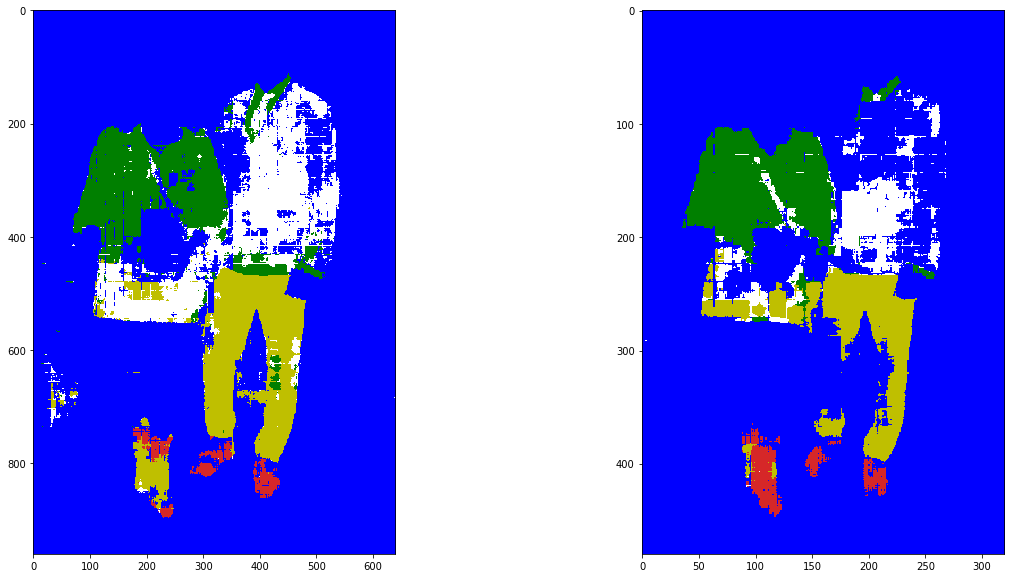

(array([ 0,  1,  5,  7, 11]), array([461957,  45617,  44498,  56867,   5461]))


In [ ]:
import cv2
img =np.copy(new_photos[10][None,...])
p_big = model_diff_size.predict(img)
dsize=(int(img[0].shape[0]/2), int(img[0].shape[1]/2))
dsize = (ceil(dsize[1]/32.0)*32,ceil(dsize[0]/32.0)*32)
print(img[0].shape)
img_small = cv2.resize(img[0], dsize, interpolation=cv2.INTER_CUBIC)[None,:,:,:]
print(img_small.shape)
p_small =model_diff_size.predict(img_small)
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(create_mask(p_big[0],0,0),interpolation='nearest',cmap=cmap,norm=norm)
plt.subplot(122)
plt.imshow(create_mask(p_small[0],0,0),interpolation='nearest',cmap=cmap,norm=norm)
plt.show()
print(np.unique(create_mask(p_big[0],0,0),return_counts=True))

In [ ]:
!pip install simpsom

  Created wheel for simpsom: filename=SimpSOM-1.3.4-cp36-none-any.whl size=17087 sha256=eb97c87416435c081070827fe6e1881999595932666703d6b374559f3f1a71c4
  Stored in directory: /root/.cache/pip/wheels/51/76/ee/c02f0bc20af4cd8f46ee4142ebf7bb654b737d6d8f2360d26b
Successfully built simpsom


In [ ]:
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt
from scipy.special import softmax
n_segs = 300
segments = slic(p_big[0].astype('double'), n_segments = n_segs, sigma = 1.0,compactness=10)
fig = plt.figure("Superpixels -- %d segments" % (numSegments),figsize=(20,10))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(mark_boundaries(img[0], segments))
plt.axis("off")
# show the plots
plt.subplot(132)
plt.imshow(create_mask(p_big[0],thres=0,thres_replace=NUMBER_OF_CATEGORIES+1),interpolation='nearest',cmap=cmap,norm=norm)
merged_masks = merge_prob_mask_with_lsc(softmax(p_big[0],axis=-1),segments,n_segs)
plt.subplot(133)
plt.imshow(merged_masks,interpolation='nearest',cmap=cmap,norm=norm)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
for i in range(14):
  plt.subplot(2,7,i+1)
  plt.imshow(p_big[0,:,:,i])
plt.show()

In [ ]:
def merge_prob_mask_with_lsc(mask,segs,n_segs):
  
  flat_mask =mask.reshape((-1,NUMBER_OF_CATEGORIES+1))
  flat_segs=segs.flatten()
  out = np.zeros(flat_segs.shape,dtype=np.uint8)
  for i in range(n_segs):
    pixel_indices = np.nonzero(flat_segs==i)[0]
    if(pixel_indices.size==0):continue
    mask_pixels = flat_mask[pixel_indices]
    class_values = np.sum(mask_pixels,axis=0) 
 
    chosen_class = np.argmax(class_values)
    out[pixel_indices]=chosen_class
  out = np.reshape(out,newshape=segs.shape)
  return out
